In [1]:
__depends__ = [
    "../../data/submission-template/rcmip-data-submission-template.xlsx",
    "../../data/cmip6/concentrations",
    "../../data/cmip5/concentrations",
]
__dest__ = [
    "../../data/protocol/rcmip-concentrations.csv",
    "../../data/protocol/rcmip-concentrations-annual-means.csv",
]

In [2]:
DATA_PROTOCOL = __depends__[0]
DATA_DIR_CMIP6 = __depends__[1]
DATA_DIR_CMIP5 = __depends__[2]

OUTPUT_FILE = __dest__[0]
OUTPUT_FILE_ANNUAL_MEAN = __dest__[1]

In [3]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# RCMIP concentration input generation

In this notebook we specify how we generated the concentration input protocol for RCMIP.

## Imports

In [4]:
import datetime as dt
import dateutil.relativedelta as rdt
import glob
import os.path
from distutils.util import strtobool

import numpy as np
import pandas as pd
import pyam
import tqdm
from netcdf_scm.misc_readers import read_cmip6_concs_gmnhsh
from scmdata import df_append, ScmDataFrame
from pymagicc.io import MAGICCData

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
from utils import SSP370_LOWNTCF_AERCHEMMIP_REFERENCE_VARIABLES

<IPython.core.display.Javascript object>

In [6]:
TEST_RUN = strtobool(os.getenv("CI", "False")) or False
TEST_RUN

False

<IPython.core.display.Javascript object>

In [7]:
REGRESSION_DIR = os.path.join("..", "..", "tests", "regression", "protocol")
REGRESSION_DIR

'../../tests/regression/protocol'

<IPython.core.display.Javascript object>

## Protocol

In [8]:
protocol_variables = pd.read_excel(DATA_PROTOCOL, sheet_name="variable_definitions")
protocol_variables.head()

idx                    Category  \
0    1  Atmospheric Concentrations   
1    2  Atmospheric Concentrations   
2    3  Atmospheric Concentrations   
3    4  Atmospheric Concentrations   
4    5  Atmospheric Concentrations   

                                        Variable Unit  \
0                 Atmospheric Concentrations|CH4  ppb   
1                 Atmospheric Concentrations|CO2  ppm   
2             Atmospheric Concentrations|F-Gases  ppm   
3         Atmospheric Concentrations|F-Gases|HFC  ppm   
4  Atmospheric Concentrations|F-Gases|HFC|HFC125  ppt   

                                          Definition  Tier  
0                  atmospheric concentrations of CH4     1  
1                  atmospheric concentrations of CO2     1  
2  equivalent species atmospheric concentrations ...     3  
3  equivalent species atmospheric concentrations ...     3  
4               atmospheric concentrations of HFC125     2

<IPython.core.display.Javascript object>

In [9]:
protocol_scenarios = pd.read_excel(
    DATA_PROTOCOL, sheet_name="scenario_info", skip_rows=2
)
protocol_scenarios.head()

Unnamed: 0                                           Scenario  \
0  Instructions/Details  Scenario identifier used in the CMIP6 modeling...   
1               Answers                                      # Scenario ID   
2                   NaN                                          piControl   
3                   NaN                                      esm-piControl   
4                   NaN                               esm-piControl-allGHG   

                             Description of scenario  \
0                     Brief description of scenario    
1                             # Scenario Description   
2  pre-industrial control simulation (i.e. consta...   
3  pre-industrial control simulation with zero an...   
4  pre-industrial control simulation with zero an...   

                       Detailed scenario description  \
0  Documentation on es-doc + some other clarifyin...   
1                            #Scenario Specification   
2  groups should run as long as is sensible/they ...   
3  should be identical to piControl except CO2 is...   
4  should be identical to piControl except all GH...   

                                            Priority  
0  Top priority is Tier 1, additional runs are Ti...  
1                                     # Tier in RCMP  
2                                                  1  
3                                                  1  
4                                                  2

<IPython.core.display.Javascript object>

## CMIP6

We generate these from the [ESGF data](https://esgf-node.llnl.gov/search/input4mips/) (search for Institution ID equal to 'UoM' and Grid Label equal to 'gr1-GMNHSH') based on [Meinshausen et al. 2019 GMDD](https://www.geosci-model-dev-discuss.net/gmd-2019-222/).

In [10]:
all_hist_cmip6_files = glob.glob(os.path.join(DATA_DIR_CMIP6, "*000001-201412*"))
all_hist_cmip6 = []
for f in tqdm.tqdm_notebook(all_hist_cmip6_files, total=len(all_hist_cmip6_files)):
    if TEST_RUN:
        if not any(
            [v in f for v in ["carbon-dioxide", "methane", "nitrous-oxide", "c2f6"]]
        ):
            continue
    all_hist_cmip6.append(read_cmip6_concs_gmnhsh(f))

all_hist_cmip6 = df_append(all_hist_cmip6).timeseries().reset_index()
all_hist_cmip6["scenario"] = "historical"
all_hist_cmip6 = ScmDataFrame(all_hist_cmip6)

<IPython.core.display.Javascript object>

In [11]:
all_hist_cmip6.head()

time                                                                                                                                                              0001-01-17 12:00:00  \
model       scenario   region                    variable                              unit activity_id climate_model member_id   mip_era variable_standard_name                        
unspecified historical World                     mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              654.127563   
                                                 mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              267.428284   
                       World|Northern Hemisphere mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              678.761963   
                                                 mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              267.782593   
                       World|Southern Hemisphere mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              629.493164   

time                                                                                                                                                              0001-02-16 00:00:00  \
model       scenario   region                    variable                              unit activity_id climate_model member_id   mip_era variable_standard_name                        
unspecified historical World                     mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              654.059692   
                                                 mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              267.374298   
                       World|Northern Hemisphere mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              679.119873   
                                                 mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              267.755920   
                       World|Southern Hemisphere mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              628.999451   

time                                                                                                                                                              0001-03-17 12:00:00  \
model       scenario   region                    variable                              unit activity_id climate_model member_id   mip_era variable_standard_name                        
unspecified historical World                     mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              653.657532   
                                                 mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              267.324615   
                       World|Northern Hemisphere mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              678.743896   
                                                 mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              267.756866   
                       World|Southern Hemisphere mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              628.571167   

time                                                                                                            

<IPython.core.display.Javascript object>

In [12]:
all_scen_cmip6_files_cmip6 = glob.glob(os.path.join(DATA_DIR_CMIP6, "*201501-250012*"))
all_scen_cmip6 = []
for f in tqdm.tqdm_notebook(
    all_scen_cmip6_files_cmip6, total=len(all_scen_cmip6_files_cmip6)
):
    if TEST_RUN:
        if not any(
            [v in f for v in ["carbon-dioxide", "methane", "nitrous-oxide", "c2f6"]]
        ):
            continue
    all_scen_cmip6.append(read_cmip6_concs_gmnhsh(f))

all_scen_cmip6 = df_append(all_scen_cmip6)

<IPython.core.display.Javascript object>

In [13]:
def join_hist_to_scen_wrangle_nans(hist_scmdf, scen_scmdf):
    hist_copy = hist_scmdf.timeseries()
    idx = hist_copy.index.names
    hist_copy = hist_copy.reset_index()
    hist_copy["scenario"] = scen_scmdf["scenario"].unique()[0]
    hist_copy["model"] = scen_scmdf["model"].unique()[0]
    hist_copy = hist_copy.set_index(idx)
    long_scen = pd.concat(
        [hist_copy, scen_scmdf.timeseries()], axis=1, sort=False
    ).reset_index()
    long_scen["variable_standard_name"] = long_scen["variable_standard_name"].fillna(
        "N/A"
    )
    long_scen = ScmDataFrame(long_scen)

    return long_scen

<IPython.core.display.Javascript object>

In [14]:
all_hist_cmip6.filter(year=range(1700, 3000)).head()

time                                                                                                                                                              1700-01-17 12:00:00  \
model       scenario   region                    variable                              unit activity_id climate_model member_id   mip_era variable_standard_name                        
unspecified historical World                     mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              708.439209   
                                                 mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              272.342529   
                       World|Northern Hemisphere mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              725.522400   
                                                 mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              272.696808   
                       World|Southern Hemisphere mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              691.355957   

time                                                                                                                                                              1700-02-16 00:00:00  \
model       scenario   region                    variable                              unit activity_id climate_model member_id   mip_era variable_standard_name                        
unspecified historical World                     mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              707.660095   
                                                 mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              272.290314   
                       World|Northern Hemisphere mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              725.226135   
                                                 mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              272.672363   
                       World|Southern Hemisphere mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              690.093994   

time                                                                                                                                                              1700-03-17 12:00:00  \
model       scenario   region                    variable                              unit activity_id climate_model member_id   mip_era variable_standard_name                        
unspecified historical World                     mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              706.671204   
                                                 mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              272.242676   
                       World|Northern Hemisphere mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              724.288025   
                                                 mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              272.676300   
                       World|Southern Hemisphere mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              689.054382   

time                                                                                                            

<IPython.core.display.Javascript object>

In [15]:
all_hist_cmip6_base = all_hist_cmip6.filter(year=range(1700, 3000))
joint_scens_cmip6 = [all_hist_cmip6_base]
for scenario in tqdm.tqdm_notebook(all_scen_cmip6["scenario"].unique()):
    joint_scens_cmip6.append(
        join_hist_to_scen_wrangle_nans(
            all_hist_cmip6_base, all_scen_cmip6.filter(scenario=scenario)
        )
    )

joint_scens_cmip6 = df_append(joint_scens_cmip6)

<IPython.core.display.Javascript object>

In [16]:
joint_scens_cmip6.head()

time                                                                                                                                                            1700-01-17 12:00:00  \
model scenario       region                    variable                              unit activity_id climate_model member_id   mip_era variable_standard_name                        
AIM   ssp370         World                     mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   N/A                              708.439209   
      ssp370-lowNTCF World                     mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   N/A                              708.439209   
      ssp370         World                     mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   N/A                              272.342529   
      ssp370-lowNTCF World                     mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   N/A                              272.342529   
      ssp370         World|Northern Hemisphere mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   N/A                              725.522400   

time                                                                                                                                                            1700-02-16 00:00:00  \
model scenario       region                    variable                              unit activity_id climate_model member_id   mip_era variable_standard_name                        
AIM   ssp370         World                     mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   N/A                              707.660095   
      ssp370-lowNTCF World                     mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   N/A                              707.660095   
      ssp370         World                     mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   N/A                              272.290314   
      ssp370-lowNTCF World                     mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   N/A                              272.290314   
      ssp370         World|Northern Hemisphere mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   N/A                              725.226135   

time                                                                                                                                                            1700-03-17 12:00:00  \
model scenario       region                    variable                              unit activity_id climate_model member_id   mip_era variable_standard_name                        
AIM   ssp370         World                     mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   N/A                              706.671204   
      ssp370-lowNTCF World                     mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   N/A                              706.671204   
      ssp370         World                     mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   N/A                              272.242676   
      ssp370-lowNTCF World                     mole_fraction_of_nitrous_oxide_in_air ppb  input4MIPs  MAGICC7       unspecified CMIP6   N/A                              272.242676   
      ssp370         World|Northern Hemisphere mole_fraction_of_methane_in_air       ppb  input4MIPs  MAGICC7       unspecified CMIP6   N/A                              724.288025   

time                                                                                                                                                      

<IPython.core.display.Javascript object>

In [17]:
joint_scens_cmip6.tail()

time                                                                                                                                                                1700-01-17 12:00:00  \
model       scenario   region                    variable                                unit activity_id climate_model member_id   mip_era variable_standard_name                        
unspecified historical World|Southern Hemisphere mole_fraction_of_methyl_bromide_in_air  ppt  input4MIPs  MAGICC7       unspecified CMIP6   NaN                                5.297047   
                                                 mole_fraction_of_methyl_chloride_in_air ppt  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              448.397095   
                                                 mole_fraction_of_nf3_in_air             ppt  input4MIPs  MAGICC7       unspecified CMIP6   NaN                                0.000000   
                                                 mole_fraction_of_sf6_in_air             ppt  input4MIPs  MAGICC7       unspecified CMIP6   NaN                                0.000000   
                                                 mole_fraction_of_so2f2_in_air           ppt  input4MIPs  MAGICC7       unspecified CMIP6   NaN                                0.000000   

time                                                                                                                                                                1700-02-16 00:00:00  \
model       scenario   region                    variable                                unit activity_id climate_model member_id   mip_era variable_standard_name                        
unspecified historical World|Southern Hemisphere mole_fraction_of_methyl_bromide_in_air  ppt  input4MIPs  MAGICC7       unspecified CMIP6   NaN                                5.316074   
                                                 mole_fraction_of_methyl_chloride_in_air ppt  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              448.931152   
                                                 mole_fraction_of_nf3_in_air             ppt  input4MIPs  MAGICC7       unspecified CMIP6   NaN                                0.000000   
                                                 mole_fraction_of_sf6_in_air             ppt  input4MIPs  MAGICC7       unspecified CMIP6   NaN                                0.000000   
                                                 mole_fraction_of_so2f2_in_air           ppt  input4MIPs  MAGICC7       unspecified CMIP6   NaN                                0.000000   

time                                                                                                                                                                1700-03-17 12:00:00  \
model       scenario   region                    variable                                unit activity_id climate_model member_id   mip_era variable_standard_name                        
unspecified historical World|Southern Hemisphere mole_fraction_of_methyl_bromide_in_air  ppt  input4MIPs  MAGICC7       unspecified CMIP6   NaN                                5.358853   
                                                 mole_fraction_of_methyl_chloride_in_air ppt  input4MIPs  MAGICC7       unspecified CMIP6   NaN                              450.068054   
                                                 mole_fraction_of_nf3_in_air             ppt  input4MIPs  MAGICC7       unspecified CMIP6   NaN                                0.000000   
                                                 mole_fraction_of_sf6_in_air             ppt  input4MIPs  MAGICC7       unspecified CMIP6   NaN                                0.000000   
                                                 mole_fraction_of_so2f2_in_air           ppt  input4MIPs  MAGICC7       unspecified CMIP6   NaN                                0.000000   

time                                                                  

<IPython.core.display.Javascript object>

In [18]:
joint_scens_cmip6_wrangle_vars = joint_scens_cmip6.timeseries().reset_index()


def wrangle_var_name(var_in):
    new_var = (
        var_in.replace("mole_fraction_of_", "")
        .replace("_in_air", "")
        .replace("_", "")
        .upper()
    )
    new_var = (
        new_var.replace("METHANE", "CH4")
        .replace("NITROUSOXIDE", "N2O")
        .replace("CARBONDIOXIDE", "CO2")
        .replace("CARBONTETRACHLORIDE", "CCl4")
        .replace("CC4F8", "cC4F8")
        .replace("CL", "Cl")
        .replace("EQ", " Equivalent")
        .replace("HALON", "Halon")
        .replace("HCFC141B", "HCFC141b")
        .replace("HCFC142B", "HCFC142b")
        .replace("EA", "ea")
        .replace("FA", "fa")
        .replace("A", "a")
        .replace("MFC", "mfc")
        .replace("HFC4310MEE", "HFC4310mee")
        .replace("METHYLBROMIDE", "CH3Br")
        .replace("METHYLCHLORIDE", "CH3Cl")
    )

    return "Atmospheric Concentrations|{}".format(new_var)


joint_scens_cmip6_wrangle_vars["variable"] = joint_scens_cmip6_wrangle_vars[
    "variable"
].apply(wrangle_var_name)
joint_scens_cmip6_wrangle_vars = joint_scens_cmip6_wrangle_vars.drop(
    ["member_id", "climate_model", "variable_standard_name"], axis="columns"
)
joint_scens_cmip6_wrangle_vars = ScmDataFrame(joint_scens_cmip6_wrangle_vars)

<IPython.core.display.Javascript object>

In [19]:
joint_scens_cmip6_wrangle_vars["variable"].unique()

array(['Atmospheric Concentrations|CH4', 'Atmospheric Concentrations|N2O',
       'Atmospheric Concentrations|CO2',
       'Atmospheric Concentrations|C2F6',
       'Atmospheric Concentrations|C3F8',
       'Atmospheric Concentrations|C4F10',
       'Atmospheric Concentrations|C5F12',
       'Atmospheric Concentrations|C6F14',
       'Atmospheric Concentrations|C7F16',
       'Atmospheric Concentrations|C8F18',
       'Atmospheric Concentrations|cC4F8',
       'Atmospheric Concentrations|CCl4',
       'Atmospheric Concentrations|CF4',
       'Atmospheric Concentrations|CFC113',
       'Atmospheric Concentrations|CFC114',
       'Atmospheric Concentrations|CFC115',
       'Atmospheric Concentrations|CFC11',
       'Atmospheric Concentrations|CFC11 Equivalent',
       'Atmospheric Concentrations|CFC12',
       'Atmospheric Concentrations|CFC12 Equivalent',
       'Atmospheric Concentrations|CH2Cl2',
       'Atmospheric Concentrations|CH3CCl3',
       'Atmospheric Concentrations|CHCl3',
 

<IPython.core.display.Javascript object>

INFO:root:>=13 labels, not applying legend


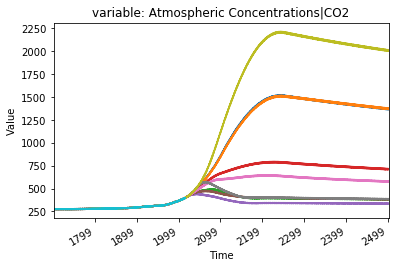

<IPython.core.display.Javascript object>

In [20]:
joint_scens_cmip6_wrangle_vars.filter(variable="*CO2*").line_plot(
    color="scenario", linestyle="region"
)

INFO:root:>=13 labels, not applying legend


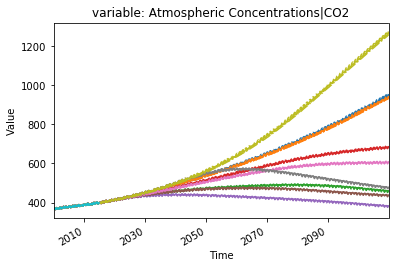

<IPython.core.display.Javascript object>

In [21]:
joint_scens_cmip6_wrangle_vars.filter(
    variable="*CO2*", year=range(2000, 2110)
).line_plot(color="scenario", linestyle="region")

INFO:root:>=13 labels, not applying legend


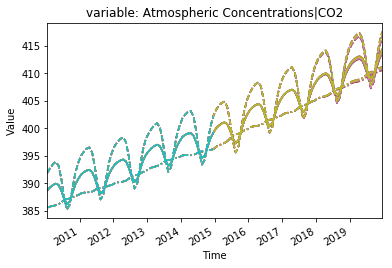

<IPython.core.display.Javascript object>

In [22]:
joint_scens_cmip6_wrangle_vars.filter(
    variable="*CO2*", year=range(2010, 2020)
).line_plot(color="scenario", linestyle="region")

In [23]:
joint_scens_cmip6_wrangle_vars.head()

time                                                                                                    1700-01-17 12:00:00  \
model scenario       region                    variable                       unit activity_id mip_era                        
AIM   ssp370         World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             708.439209   
      ssp370-lowNTCF World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             708.439209   
      ssp370         World                     Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.342529   
      ssp370-lowNTCF World                     Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.342529   
      ssp370         World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             725.522400   

time                                                                                                    1700-02-16 00:00:00  \
model scenario       region                    variable                       unit activity_id mip_era                        
AIM   ssp370         World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             707.660095   
      ssp370-lowNTCF World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             707.660095   
      ssp370         World                     Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.290314   
      ssp370-lowNTCF World                     Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.290314   
      ssp370         World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             725.226135   

time                                                                                                    1700-03-17 12:00:00  \
model scenario       region                    variable                       unit activity_id mip_era                        
AIM   ssp370         World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             706.671204   
      ssp370-lowNTCF World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             706.671204   
      ssp370         World                     Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.242676   
      ssp370-lowNTCF World                     Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.242676   
      ssp370         World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             724.288025   

time                                                                                                    1700-04-17 00:00:00  \
model scenario       region                    variable                       unit activity_id mip_era                        
AIM   ssp370         World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             705.510559   
      ssp370-lowNTCF World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             705.510559   
      ssp370         World                     Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.186462   
      ssp370-lowNTCF World                     Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.186462   
      ssp370         World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             721.966064   

time                                                                                                    1700-05-17 12:00:00  \
model scenario       region                    variable                       unit activity_id mip_era                        
AIM   ssp370         World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             704.320374   
      ssp370-lowNTCF World                     Atmospheric 

<IPython.core.display.Javascript object>

In [24]:
joint_scens_cmip6_wrangle_vars.tail()

time                                                                                                        1700-01-17 12:00:00  \
model       scenario   region                    variable                         unit activity_id mip_era                        
unspecified historical World|Southern Hemisphere Atmospheric Concentrations|CH3Br ppt  input4MIPs  CMIP6               5.297047   
                                                 Atmospheric Concentrations|CH3Cl ppt  input4MIPs  CMIP6             448.397095   
                                                 Atmospheric Concentrations|NF3   ppt  input4MIPs  CMIP6               0.000000   
                                                 Atmospheric Concentrations|SF6   ppt  input4MIPs  CMIP6               0.000000   
                                                 Atmospheric Concentrations|SO2F2 ppt  input4MIPs  CMIP6               0.000000   

time                                                                                                        1700-02-16 00:00:00  \
model       scenario   region                    variable                         unit activity_id mip_era                        
unspecified historical World|Southern Hemisphere Atmospheric Concentrations|CH3Br ppt  input4MIPs  CMIP6               5.316074   
                                                 Atmospheric Concentrations|CH3Cl ppt  input4MIPs  CMIP6             448.931152   
                                                 Atmospheric Concentrations|NF3   ppt  input4MIPs  CMIP6               0.000000   
                                                 Atmospheric Concentrations|SF6   ppt  input4MIPs  CMIP6               0.000000   
                                                 Atmospheric Concentrations|SO2F2 ppt  input4MIPs  CMIP6               0.000000   

time                                                                                                        1700-03-17 12:00:00  \
model       scenario   region                    variable                         unit activity_id mip_era                        
unspecified historical World|Southern Hemisphere Atmospheric Concentrations|CH3Br ppt  input4MIPs  CMIP6               5.358853   
                                                 Atmospheric Concentrations|CH3Cl ppt  input4MIPs  CMIP6             450.068054   
                                                 Atmospheric Concentrations|NF3   ppt  input4MIPs  CMIP6               0.000000   
                                                 Atmospheric Concentrations|SF6   ppt  input4MIPs  CMIP6               0.000000   
                                                 Atmospheric Concentrations|SO2F2 ppt  input4MIPs  CMIP6               0.000000   

time                                                                                                        1700-04-17 00:00:00  \
model       scenario   region                    variable                         unit activity_id mip_era                        
unspecified historical World|Southern Hemisphere Atmospheric Concentrations|CH3Br ppt  input4MIPs  CMIP6               5.358625   
                                                 Atmospheric Concentrations|CH3Cl ppt  input4MIPs  CMIP6             455.773376   
                                                 Atmospheric Concentrations|NF3   ppt  input4MIPs  CMIP6               0.000000   
                                                 Atmospheric Concentrations|SF6   ppt  input4MIPs  CMIP6               0.000000   
                                                 Atmospheric Concentrations|SO2F2 ppt  input4MIPs  CMIP6               0.000000   

time                                                                                                        1700-05-17 12:00:00  \
model       scenario   region                    variable                         unit activity_id mip_era                        
unspecified historical World|Southern Hemisphere Atmospheric Conce

<IPython.core.display.Javascript object>

## CMIP5

Here we take the concentrations from http://www.pik-potsdam.de/~mmalte/rcps/. These are annual global-mean values.

In [25]:
model_map = {"RCP26": "IMAGE", "RCP45": "MiniCAM", "RCP60": "AIM", "RCP85": "MESSAGE"}
all_cmip5_files = glob.glob(os.path.join(DATA_DIR_CMIP5, "*"))
all_cmip5 = []
for f in tqdm.tqdm_notebook(all_cmip5_files, total=len(all_cmip5_files)):
    tmp = MAGICCData(f).timeseries()
    tmp.columns = tmp.columns.map(lambda x: dt.datetime(x.year, 7, 2))
    tmp = tmp.reset_index()
    scenario = (
        os.path.split(f)[1]
        .split("_")[0]
        .replace("RCP6", "RCP60")
        .replace("RCP3PD", "RCP26")
    )
    tmp["scenario"] = scenario
    tmp["model"] = model_map[scenario]

    all_cmip5.append(tmp)


all_cmip5 = df_append(all_cmip5)
years_to_keep = all_cmip5["time"].apply(lambda x: x.year).tolist()

all_cmip5 = all_cmip5.timeseries()
all_cmip5["parameter_type"] = "point"
all_cmip5.loc[:, all_cmip5.columns[0] - rdt.relativedelta(years=1)] = all_cmip5.loc[
    :, all_cmip5.columns[0]
]

all_cmip5 = ScmDataFrame(all_cmip5)
all_cmip5 = all_cmip5.interpolate(
    joint_scens_cmip6_wrangle_vars.filter(year=years_to_keep)["time"].values.squeeze()
)

cmip5_hist = (
    all_cmip5.filter(scenario="RCP26", year=range(1765, 2006))
    .timeseries()
    .reset_index()
)
cmip5_hist["model"] = "unspecified"
cmip5_hist["scenario"] = "historical-cmip5"

all_cmip5 = df_append([all_cmip5, cmip5_hist]).timeseries().reset_index()
all_cmip5 = all_cmip5.drop(["climate_model", "parameter_type", "todo"], axis="columns")
all_cmip5["mip_era"] = "CMIP5"
all_cmip5["activity_id"] = "input4MIPs"
all_cmip5["variable"] = all_cmip5["variable"].str.replace("HFC4310", "HFC4310mee")
all_cmip5["scenario"] = all_cmip5["scenario"].str.lower()
all_cmip5 = ScmDataFrame(all_cmip5)

<IPython.core.display.Javascript object>

In [26]:
all_cmip5.head()

time                                                                                               1765-01-17 12:00:00  \
model scenario region variable                                           unit activity_id mip_era                        
AIM   rcp60    World  Atmospheric Concentrations|CH4                     ppb  input4MIPs  CMIP5              721.89411   
                      Atmospheric Concentrations|N2O                     ppb  input4MIPs  CMIP5              272.95961   
                      Atmospheric Concentrations|CO2                     ppm  input4MIPs  CMIP5              278.05158   
                      Atmospheric Concentrations|CO2 Equivalent          ppm  input4MIPs  CMIP5              277.01467   
                      Atmospheric Concentrations|CO2 Equivalent|Kyoto... ppm  input4MIPs  CMIP5              277.01467   

time                                                                                               1765-02-16 00:00:00  \
model scenario region variable                                           unit activity_id mip_era                        
AIM   rcp60    World  Atmospheric Concentrations|CH4                     ppb  input4MIPs  CMIP5              721.89411   
                      Atmospheric Concentrations|N2O                     ppb  input4MIPs  CMIP5              272.95961   
                      Atmospheric Concentrations|CO2                     ppm  input4MIPs  CMIP5              278.05158   
                      Atmospheric Concentrations|CO2 Equivalent          ppm  input4MIPs  CMIP5              277.01467   
                      Atmospheric Concentrations|CO2 Equivalent|Kyoto... ppm  input4MIPs  CMIP5              277.01467   

time                                                                                               1765-03-17 12:00:00  \
model scenario region variable                                           unit activity_id mip_era                        
AIM   rcp60    World  Atmospheric Concentrations|CH4                     ppb  input4MIPs  CMIP5              721.89411   
                      Atmospheric Concentrations|N2O                     ppb  input4MIPs  CMIP5              272.95961   
                      Atmospheric Concentrations|CO2                     ppm  input4MIPs  CMIP5              278.05158   
                      Atmospheric Concentrations|CO2 Equivalent          ppm  input4MIPs  CMIP5              277.01467   
                      Atmospheric Concentrations|CO2 Equivalent|Kyoto... ppm  input4MIPs  CMIP5              277.01467   

time                                                                                               1765-04-17 00:00:00  \
model scenario region variable                                           unit activity_id mip_era                        
AIM   rcp60    World  Atmospheric Concentrations|CH4                     ppb  input4MIPs  CMIP5              721.89411   
                      Atmospheric Concentrations|N2O                     ppb  input4MIPs  CMIP5              272.95961   
                      Atmospheric Concentrations|CO2                     ppm  input4MIPs  CMIP5              278.05158   
                      Atmospheric Concentrations|CO2 Equivalent          ppm  input4MIPs  CMIP5              277.01467   
                      Atmospheric Concentrations|CO2 Equivalent|Kyoto... ppm  input4MIPs  CMIP5              277.01467   

time                                                                                               1765-05-17 12:00:00  \
model scenario region variable                                           unit activity_id mip_era                        
AIM   rcp60    World  Atmospheric Concentrations|CH4                     ppb  input4MIPs  CMIP5              721.89411   
                      Atmospheric Concentrations|N2O                     ppb  input4MIPs  CMIP5              272.95961   
                      Atmospheric Concentrations|CO2                     ppm  input4MIPs  CM

<IPython.core.display.Javascript object>

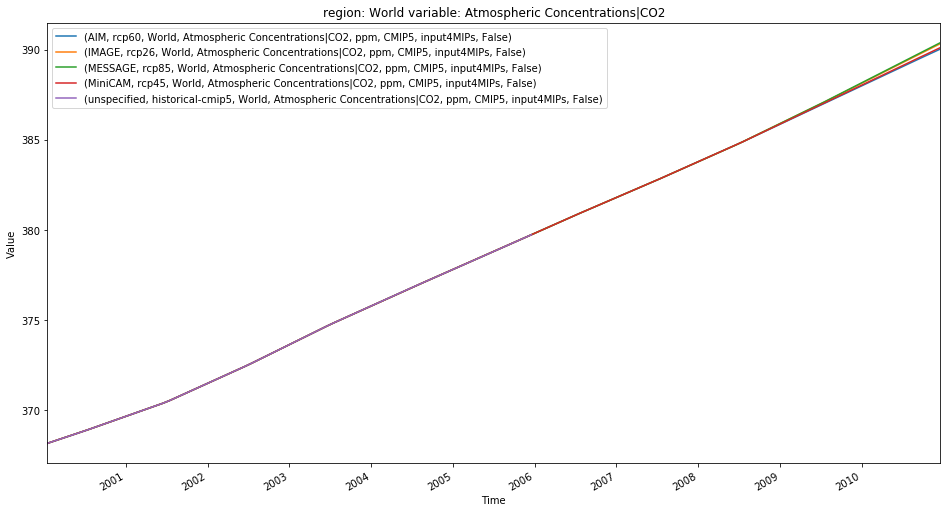

<IPython.core.display.Javascript object>

In [27]:
all_cmip5.filter(variable="*CO2", year=range(2000, 2011)).line_plot(figsize=(16, 9))

## Rename variables

In [28]:
# rename variables
joint_output = df_append([joint_scens_cmip6_wrangle_vars, all_cmip5]).filter(
    variable="*Equivalent*", keep=False
)


def variable_map(v):
    new_v = v

    if new_v.split("|")[-1] in [
        "CF4",
        "C2F6",
        "C3F8",
        "C4F10",
        "C5F12",
        "C6F14",
        "C7F16",
        "C8F18",
        "cC4F8",
    ]:
        new_v = new_v.replace(
            "Atmospheric Concentrations|", "Atmospheric Concentrations|F-Gases|PFC|"
        )

    if new_v.split("|")[-1] in [
        "CCl4",
        "CH3Br",
        "CH3CCl3",
        "CH3Cl",
        "HCFC141b",
        "HCFC142b",
        "HCFC22",
    ]:
        new_v = new_v.replace(
            "Atmospheric Concentrations|", "Atmospheric Concentrations|Montreal Gases|"
        )

    if "HFC" in new_v.split("|")[-1]:
        new_v = new_v.replace(
            "Atmospheric Concentrations|", "Atmospheric Concentrations|F-Gases|HFC|"
        )

    if new_v.split("|")[-1] in ["SF6", "NF3", "SO2F2"]:
        new_v = new_v.replace(
            "Atmospheric Concentrations|", "Atmospheric Concentrations|F-Gases|"
        )

    if "Halon" in new_v.split("|")[-1] or new_v.split("|")[-1] in ["CH2Cl2", "CHCl3"]:
        new_v = new_v.replace(
            "Atmospheric Concentrations|", "Atmospheric Concentrations|Montreal Gases|"
        )

    if new_v.split("|")[-1] in ["CFC11", "CFC12", "CFC113", "CFC114", "CFC115"]:
        new_v = new_v.replace(
            "Atmospheric Concentrations|",
            "Atmospheric Concentrations|Montreal Gases|CFC|",
        )

    return new_v


joint_output = joint_output.timeseries().reset_index()
joint_output["variable"] = joint_output["variable"].apply(variable_map)
joint_output = ScmDataFrame(joint_output)

<IPython.core.display.Javascript object>

### ssp370-lowNTCF

ssp370-lowNTCF as defined by [AerChemMIP](https://www.geosci-model-dev.net/10/585/2017/gmd-10-585-2017.pdf) differs from [Gidden et al. 2019](https://www.geosci-model-dev.net/12/1443/2019/). To make them clear, we add the suffixes `-aerchemmip` and `-gidden` respectively and make the scenarios as intended by each set of specifications.

In [29]:
joint_output["scenario"].unique()

array(['rcp60', 'ssp370', 'ssp370-lowNTCF', 'ssp434', 'ssp460', 'rcp26',
       'ssp119', 'ssp126', 'rcp85', 'ssp245', 'rcp45', 'ssp534-over',
       'ssp585', 'historical-cmip5', 'historical'], dtype=object)

<IPython.core.display.Javascript object>

In [30]:
ssp370_lowntcf_gidden = (
    joint_output.filter(scenario="ssp370-lowNTCF").timeseries().reset_index()
)
ssp370_lowntcf_gidden["scenario"] = "ssp370-lowNTCF-gidden"
ssp370_lowntcf_gidden = ScmDataFrame(ssp370_lowntcf_gidden)
ssp370_lowntcf_gidden.head()

time                                                                                                           1700-01-17 12:00:00  \
model scenario              region                    variable                       unit activity_id mip_era                        
AIM   ssp370-lowNTCF-gidden World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             708.439209   
                                                      Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.342529   
                            World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             725.522400   
                                                      Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.696808   
                            World|Southern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             691.355957   

time                                                                                                           1700-02-16 00:00:00  \
model scenario              region                    variable                       unit activity_id mip_era                        
AIM   ssp370-lowNTCF-gidden World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             707.660095   
                                                      Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.290314   
                            World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             725.226135   
                                                      Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.672363   
                            World|Southern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             690.093994   

time                                                                                                           1700-03-17 12:00:00  \
model scenario              region                    variable                       unit activity_id mip_era                        
AIM   ssp370-lowNTCF-gidden World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             706.671204   
                                                      Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.242676   
                            World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             724.288025   
                                                      Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.676300   
                            World|Southern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             689.054382   

time                                                                                                           1700-04-17 00:00:00  \
model scenario              region                    variable                       unit activity_id mip_era                        
AIM   ssp370-lowNTCF-gidden World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             705.510559   
                                                      Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.186462   
                            World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             721.966064   
                                                      Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.644043   
                            World|Southern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             689.054993   

time                                                                                                           1700-05-17 12:00:00  \
model scenario              region                    variable                       unit activity_id mip_era 

<IPython.core.display.Javascript object>

In [31]:
SSP370_LOWNTCF_AERCHEMMIP_REFERENCE_VARIABLES

['*CO2*', '*CH4*', '*N2O*', '*F-Gases*', '*Montreal Gases*']

<IPython.core.display.Javascript object>

In [32]:
ssp370_aerchemmip_reference_variable_ts = (
    joint_output.filter(
        scenario="ssp370", variable=SSP370_LOWNTCF_AERCHEMMIP_REFERENCE_VARIABLES
    )
    .timeseries()
    .reset_index()
)
ssp370_aerchemmip_reference_variable_ts["scenario"] = "ssp370-lowNTCF-aerchemmip"
ssp370_lowntcf_aerchemmip = ScmDataFrame(ssp370_aerchemmip_reference_variable_ts)
ssp370_lowntcf_aerchemmip.head()

time                                                                                                               1700-01-17 12:00:00  \
model scenario                  region                    variable                       unit activity_id mip_era                        
AIM   ssp370-lowNTCF-aerchemmip World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             708.439209   
                                                          Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.342529   
                                World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             725.522400   
                                                          Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.696808   
                                World|Southern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             691.355957   

time                                                                                                               1700-02-16 00:00:00  \
model scenario                  region                    variable                       unit activity_id mip_era                        
AIM   ssp370-lowNTCF-aerchemmip World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             707.660095   
                                                          Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.290314   
                                World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             725.226135   
                                                          Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.672363   
                                World|Southern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             690.093994   

time                                                                                                               1700-03-17 12:00:00  \
model scenario                  region                    variable                       unit activity_id mip_era                        
AIM   ssp370-lowNTCF-aerchemmip World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             706.671204   
                                                          Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.242676   
                                World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             724.288025   
                                                          Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.676300   
                                World|Southern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             689.054382   

time                                                                                                               1700-04-17 00:00:00  \
model scenario                  region                    variable                       unit activity_id mip_era                        
AIM   ssp370-lowNTCF-aerchemmip World                     Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             705.510559   
                                                          Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.186462   
                                World|Northern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             721.966064   
                                                          Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP6             272.644043   
                                World|Southern Hemisphere Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             689.054993   

time                                                                                                               1700-05-17 12:00:

<IPython.core.display.Javascript object>

In [33]:
joint_output = (
    joint_output.filter(scenario="ssp370-lowNTCF*", keep=False)
    .append(ssp370_lowntcf_gidden)
    .append(ssp370_lowntcf_aerchemmip)
)
joint_output["scenario"].unique()

array(['rcp60', 'ssp370', 'ssp370-lowNTCF-aerchemmip',
       'ssp370-lowNTCF-gidden', 'ssp434', 'ssp460', 'rcp26', 'ssp119',
       'ssp126', 'rcp85', 'ssp245', 'rcp45', 'ssp534-over', 'ssp585',
       'historical-cmip5', 'historical'], dtype=object)

<IPython.core.display.Javascript object>

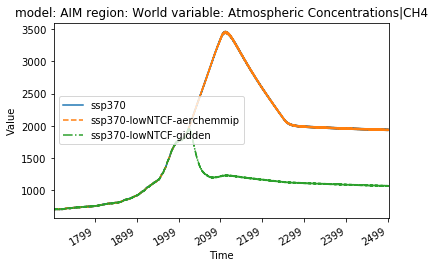

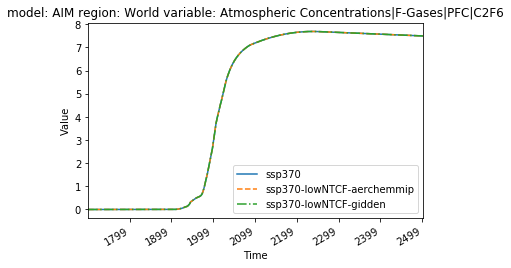

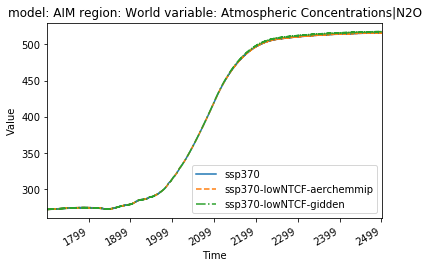

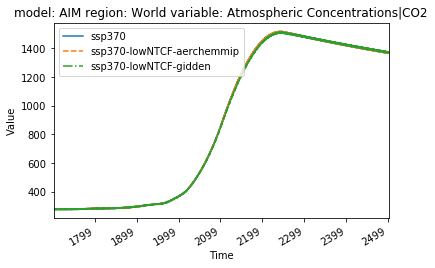

<IPython.core.display.Javascript object>

In [34]:
joint_output.filter(scenario="ssp370*", region="World").filter(
    variable="*CH4"
).line_plot(linestyle="scenario")

joint_output.filter(scenario="ssp370*", region="World").filter(
    variable="*C2F6"
).line_plot(linestyle="scenario")

joint_output.filter(scenario="ssp370*", region="World").filter(
    variable="*N2O"
).line_plot(linestyle="scenario")

joint_output.filter(scenario="ssp370*", region="World").filter(
    variable="*CO2"
).line_plot(linestyle="scenario")

## Save monthly concentrations

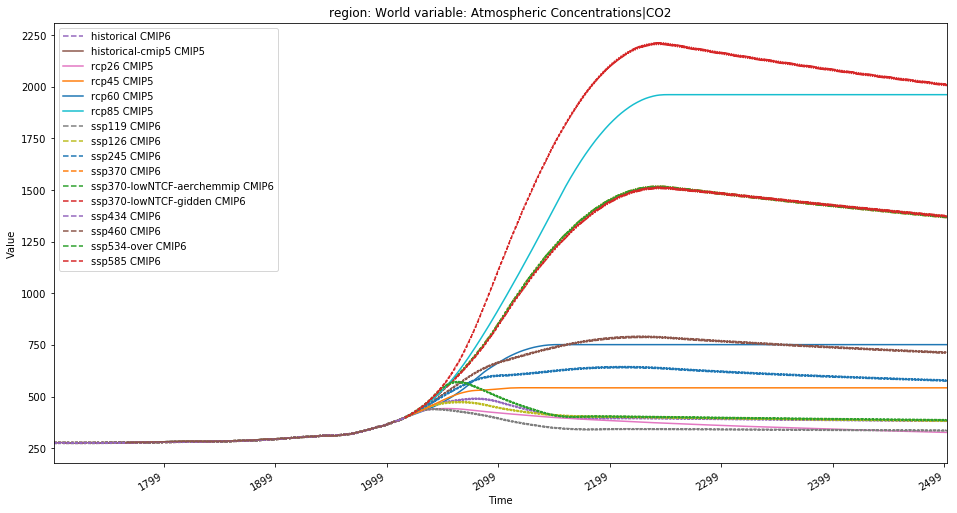

<IPython.core.display.Javascript object>

In [35]:
joint_output.filter(variable="*CO2", region="World").line_plot(
    color="scenario", linestyle="mip_era", figsize=(16, 9), legend=True
)

In [36]:
joint_output.filter(year=range(1800, 1900)).head()

time                                                                                            1800-01-17 12:00:00  \
model scenario                  region variable                       unit activity_id mip_era                        
AIM   rcp60                     World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP5             741.257289   
                                       Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP5             273.664702   
      ssp370                    World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             760.085754   
      ssp370-lowNTCF-aerchemmip World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             760.085754   
      ssp370-lowNTCF-gidden     World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             760.085754   

time                                                                                            1800-02-16 00:00:00  \
model scenario                  region variable                       unit activity_id mip_era                        
AIM   rcp60                     World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP5             741.319818   
                                       Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP5             273.666511   
      ssp370                    World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             759.292175   
      ssp370-lowNTCF-aerchemmip World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             759.292175   
      ssp370-lowNTCF-gidden     World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             759.292175   

time                                                                                            1800-03-17 12:00:00  \
model scenario                  region variable                       unit activity_id mip_era                        
AIM   rcp60                     World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP5             741.382348   
                                       Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP5             273.668320   
      ssp370                    World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             758.273010   
      ssp370-lowNTCF-aerchemmip World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             758.273010   
      ssp370-lowNTCF-gidden     World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             758.273010   

time                                                                                            1800-04-17 00:00:00  \
model scenario                  region variable                       unit activity_id mip_era                        
AIM   rcp60                     World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP5             741.446997   
                                       Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP5             273.670190   
      ssp370                    World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             757.069397   
      ssp370-lowNTCF-aerchemmip World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             757.069397   
      ssp370-lowNTCF-gidden     World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             757.069397   

time                                                                                            1800-05-17 12:00:00  \
model scenario                  region variable                       unit activity_id mip_era                        
AIM   rcp60                     World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP5             741.511646   
                                       Atmospheric Concentrations|N2O ppb  input4MIPs  CMIP5             273.672060   
      ssp370                    World  Atmospheric Concentrations|CH4 ppb  input4MIPs  CMIP6             755.834167   
      ssp370-lowNTCF-aerchemmip World  Atmospheric Concentrations|CH4

<IPython.core.display.Javascript object>

In [37]:
joint_output.to_csv(OUTPUT_FILE)
if TEST_RUN:
    now = pd.read_csv(OUTPUT_FILE)
    reg = pd.read_csv(os.path.join(REGRESSION_DIR, os.path.basename(OUTPUT_FILE)))
    pd.testing.assert_frame_equal(
        now, reg, check_like=True
    ), "{} regression test failed".format(os.path.basename(OUTPUT_FILE))

<IPython.core.display.Javascript object>

Conversion to annual means

In [38]:
annual_means = joint_output.time_mean("AC").timeseries()
annual_means.columns = annual_means.columns.map(lambda x: x.year)
annual_means = pyam.IamDataFrame(annual_means)
annual_means.head()

model scenario region                        variable unit  year  \
0   AIM    rcp60  World  Atmospheric Concentrations|CH4  ppb  1765   
1   AIM    rcp60  World  Atmospheric Concentrations|CH4  ppb  1766   
2   AIM    rcp60  World  Atmospheric Concentrations|CH4  ppb  1767   
3   AIM    rcp60  World  Atmospheric Concentrations|CH4  ppb  1768   
4   AIM    rcp60  World  Atmospheric Concentrations|CH4  ppb  1769   

  activity_id mip_era       value  
0  input4MIPs   CMIP5  721.939763  
1  input4MIPs   CMIP5  722.301037  
2  input4MIPs   CMIP5  722.968087  
3  input4MIPs   CMIP5  723.666190  
4  input4MIPs   CMIP5  724.341526

<IPython.core.display.Javascript object>

## Idealised experiments

In [39]:
pi_control = annual_means.filter(scenario="historical", year=1850).timeseries()
for y in np.arange(1851, 2501):
    pi_control[y] = pi_control[1850]

pi_control = pi_control.reset_index()
pi_control["scenario"] = "piControl"
pi_control = pyam.IamDataFrame(pi_control)
pi_control.head()

model   scenario region                        variable unit  year  \
0  unspecified  piControl  World  Atmospheric Concentrations|CH4  ppb  1850   
1  unspecified  piControl  World  Atmospheric Concentrations|CH4  ppb  1851   
2  unspecified  piControl  World  Atmospheric Concentrations|CH4  ppb  1852   
3  unspecified  piControl  World  Atmospheric Concentrations|CH4  ppb  1853   
4  unspecified  piControl  World  Atmospheric Concentrations|CH4  ppb  1854   

  activity_id mip_era       value  
0  input4MIPs   CMIP6  808.249029  
1  input4MIPs   CMIP6  808.249029  
2  input4MIPs   CMIP6  808.249029  
3  input4MIPs   CMIP6  808.249029  
4  input4MIPs   CMIP6  808.249029

<IPython.core.display.Javascript object>

In [40]:
one_pct_co2 = pi_control.timeseries()
growth = one_pct_co2.columns.map(lambda x: 1.01 ** (x - 1850)).values
co2_vals = one_pct_co2.loc[
    one_pct_co2.index.get_level_values("variable") == "Atmospheric Concentrations|CO2",
    :,
].values
one_pct_co2.loc[
    one_pct_co2.index.get_level_values("variable") == "Atmospheric Concentrations|CO2",
    :,
] = (co2_vals * growth)
one_pct_co2 = one_pct_co2.reset_index()
one_pct_co2["scenario"] = "1pctCO2"
one_pct_co2 = pyam.IamDataFrame(one_pct_co2)
one_pct_co2.head()

model scenario region                        variable unit  year  \
0  unspecified  1pctCO2  World  Atmospheric Concentrations|CH4  ppb  1850   
1  unspecified  1pctCO2  World  Atmospheric Concentrations|CH4  ppb  1851   
2  unspecified  1pctCO2  World  Atmospheric Concentrations|CH4  ppb  1852   
3  unspecified  1pctCO2  World  Atmospheric Concentrations|CH4  ppb  1853   
4  unspecified  1pctCO2  World  Atmospheric Concentrations|CH4  ppb  1854   

  activity_id mip_era       value  
0  input4MIPs   CMIP6  808.249029  
1  input4MIPs   CMIP6  808.249029  
2  input4MIPs   CMIP6  808.249029  
3  input4MIPs   CMIP6  808.249029  
4  input4MIPs   CMIP6  808.249029

<IPython.core.display.Javascript object>

In [41]:
one_pct_co2_ext = one_pct_co2.filter(year=range(1850, 1991)).timeseries()
atmospheric_co2_rows = (
    one_pct_co2_ext.index.get_level_values("variable")
    == "Atmospheric Concentrations|CO2"
)
# force 1990 value to match 4xCO2 exactly
one_pct_co2_ext.loc[atmospheric_co2_rows, 1990] = (
    one_pct_co2_ext.loc[atmospheric_co2_rows, 1850] * 4
)
for y in range(1990, 2501):
    one_pct_co2_ext[y] = one_pct_co2_ext[1990]
one_pct_co2_ext = one_pct_co2_ext.reset_index()
one_pct_co2_ext["scenario"] = "1pctCO2-4xext"
one_pct_co2_ext = pyam.IamDataFrame(one_pct_co2_ext)
one_pct_co2_ext.head()

model       scenario region                        variable unit  \
0  unspecified  1pctCO2-4xext  World  Atmospheric Concentrations|CH4  ppb   
1  unspecified  1pctCO2-4xext  World  Atmospheric Concentrations|CH4  ppb   
2  unspecified  1pctCO2-4xext  World  Atmospheric Concentrations|CH4  ppb   
3  unspecified  1pctCO2-4xext  World  Atmospheric Concentrations|CH4  ppb   
4  unspecified  1pctCO2-4xext  World  Atmospheric Concentrations|CH4  ppb   

   year activity_id mip_era       value  
0  1850  input4MIPs   CMIP6  808.249029  
1  1851  input4MIPs   CMIP6  808.249029  
2  1852  input4MIPs   CMIP6  808.249029  
3  1853  input4MIPs   CMIP6  808.249029  
4  1854  input4MIPs   CMIP6  808.249029

<IPython.core.display.Javascript object>

In [42]:
def make_abrupt_increase_df(pic, increase, scenario):
    abrupt = pi_control.timeseries()
    growth = abrupt.columns.map(lambda x: increase).values
    co2_vals = abrupt.loc[
        abrupt.index.get_level_values("variable") == "Atmospheric Concentrations|CO2", :
    ].values
    abrupt.loc[
        abrupt.index.get_level_values("variable") == "Atmospheric Concentrations|CO2", :
    ] = (co2_vals * growth)
    abrupt = abrupt.reset_index()
    abrupt["scenario"] = scenario
    abrupt = pyam.IamDataFrame(abrupt)

    return abrupt


abrupt_4xco2 = make_abrupt_increase_df(pi_control, 4, "abrupt-4xCO2")
abrupt_2xco2 = make_abrupt_increase_df(pi_control, 2, "abrupt-2xCO2")
abrupt_0p5xco2 = make_abrupt_increase_df(pi_control, 0.5, "abrupt-0p5xCO2")

abrupt_0p5xco2.head()

model        scenario region                        variable unit  \
0  unspecified  abrupt-0p5xCO2  World  Atmospheric Concentrations|CH4  ppb   
1  unspecified  abrupt-0p5xCO2  World  Atmospheric Concentrations|CH4  ppb   
2  unspecified  abrupt-0p5xCO2  World  Atmospheric Concentrations|CH4  ppb   
3  unspecified  abrupt-0p5xCO2  World  Atmospheric Concentrations|CH4  ppb   
4  unspecified  abrupt-0p5xCO2  World  Atmospheric Concentrations|CH4  ppb   

   year activity_id mip_era       value  
0  1850  input4MIPs   CMIP6  808.249029  
1  1851  input4MIPs   CMIP6  808.249029  
2  1852  input4MIPs   CMIP6  808.249029  
3  1853  input4MIPs   CMIP6  808.249029  
4  1854  input4MIPs   CMIP6  808.249029

<IPython.core.display.Javascript object>

(0, 1500)

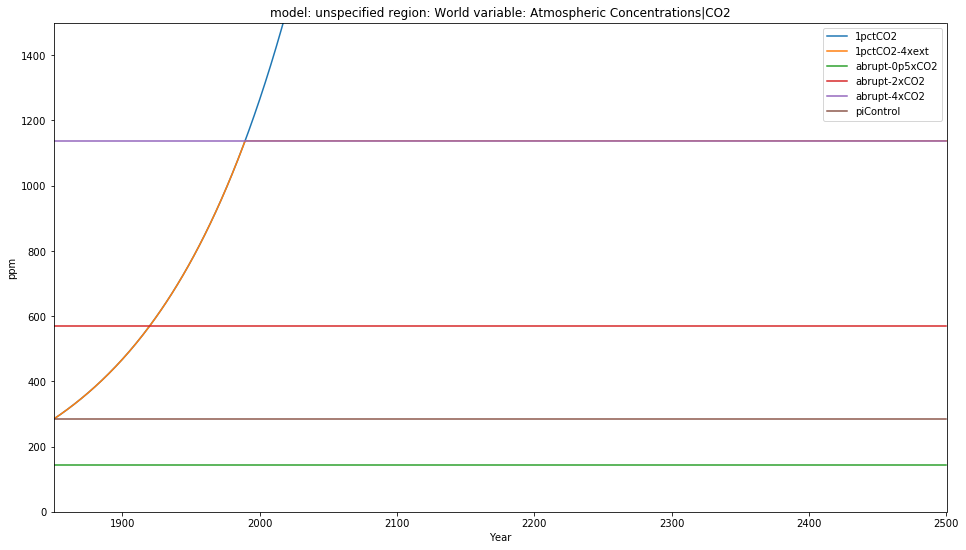

<IPython.core.display.Javascript object>

In [43]:
idealised_experiments = (
    pi_control.append(one_pct_co2)
    .append(one_pct_co2_ext)
    .append(abrupt_4xco2)
    .append(abrupt_2xco2)
    .append(abrupt_0p5xco2)
)
ax = idealised_experiments.filter(variable="*CO2", region="World").line_plot(
    figsize=(16, 9), color="scenario"
)
ax.set_ylim([0, 1500])

## Save annual-mean concentrations

In [44]:
annual_means = annual_means.append(idealised_experiments)

<IPython.core.display.Javascript object>

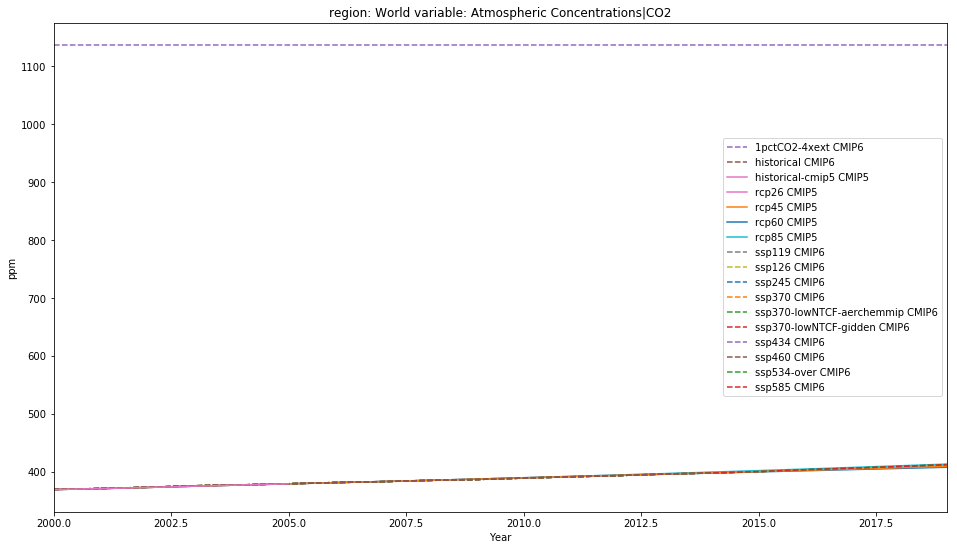

<IPython.core.display.Javascript object>

In [45]:
annual_means.filter(scenario=["piControl", "*CO2"], keep=False).filter(
    variable="*CO2", region="World", year=range(2000, 2020)
).line_plot(color="scenario", linestyle="mip_era", figsize=(16, 9), legend=True)

(0, 2500)

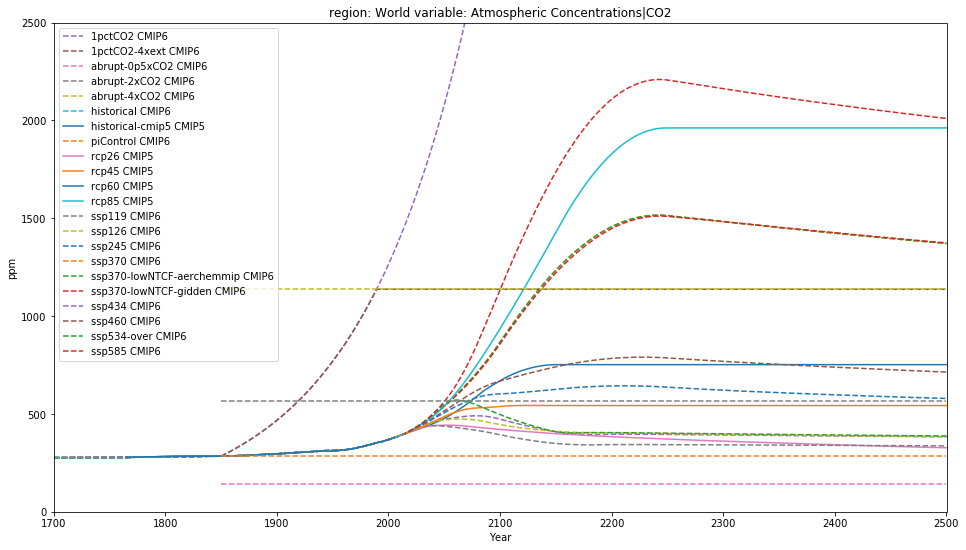

<IPython.core.display.Javascript object>

In [46]:
ax = annual_means.filter(variable="*CO2", region="World").line_plot(
    color="scenario", linestyle="mip_era", figsize=(16, 9), legend=True
)
ax.set_ylim([0, 2500])

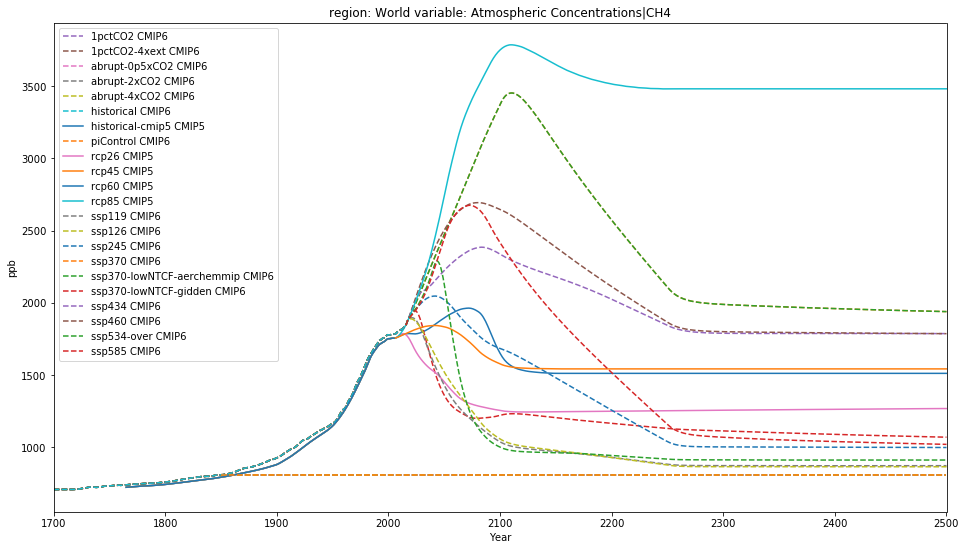

<IPython.core.display.Javascript object>

In [47]:
annual_means.filter(variable="*CH4", region="World").line_plot(
    color="scenario", linestyle="mip_era", figsize=(16, 9), legend=True
)

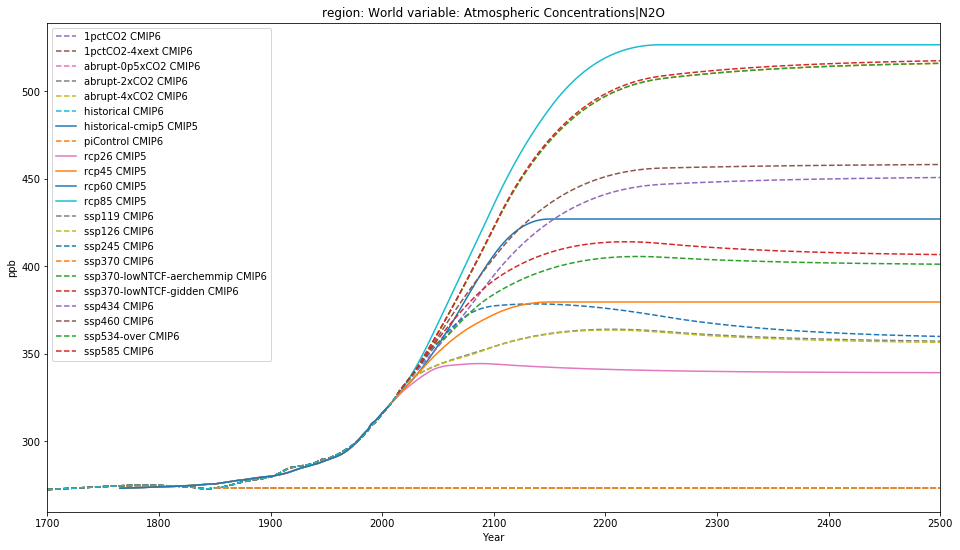

<IPython.core.display.Javascript object>

In [48]:
annual_means.filter(variable="*N2O", region="World").line_plot(
    color="scenario", linestyle="mip_era", figsize=(16, 9), legend=True
)

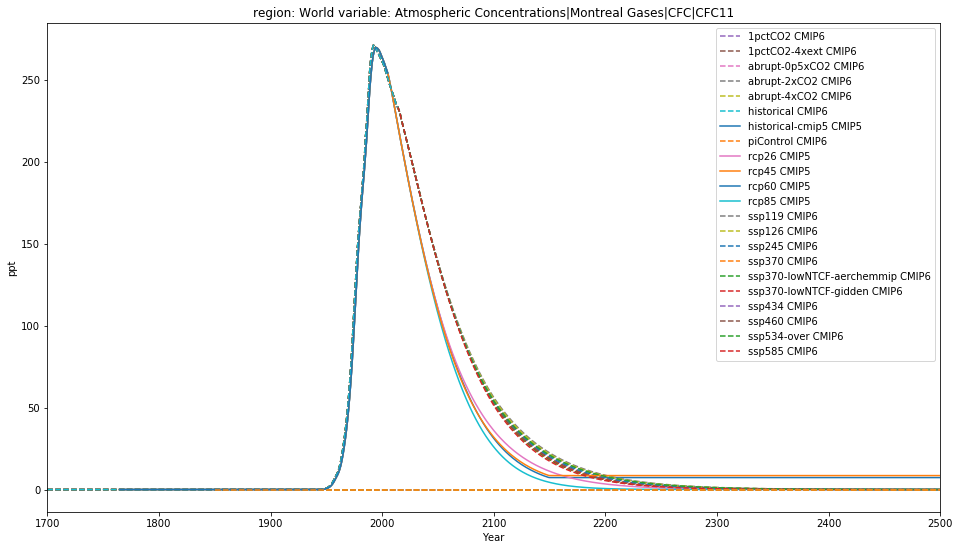

<IPython.core.display.Javascript object>

In [49]:
annual_means.filter(variable="*CFC11", region="World").line_plot(
    color="scenario", linestyle="mip_era", figsize=(16, 9), legend=True
)

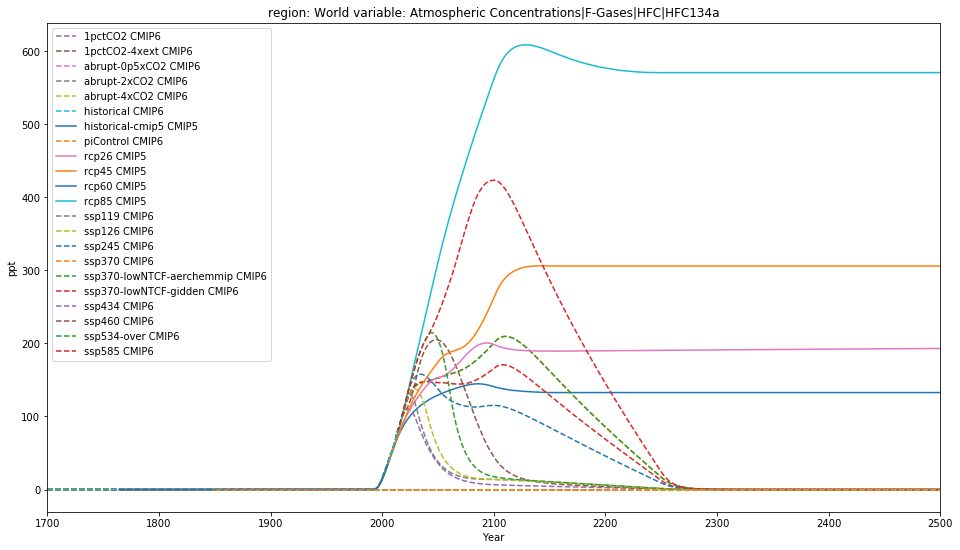

<IPython.core.display.Javascript object>

In [50]:
annual_means.filter(variable="*HFC134a", region="World").line_plot(
    color="scenario", linestyle="mip_era", figsize=(16, 9), legend=True
)

In [51]:
annual_means.to_csv(OUTPUT_FILE_ANNUAL_MEAN)
if TEST_RUN:
    now = pd.read_csv(OUTPUT_FILE_ANNUAL_MEAN)
    reg = pd.read_csv(
        os.path.join(REGRESSION_DIR, os.path.basename(OUTPUT_FILE_ANNUAL_MEAN))
    )
    pd.testing.assert_frame_equal(
        now, reg, check_like=True
    ), "{} regression test failed".format(os.path.basename(OUTPUT_FILE_ANNUAL_MEAN))

<IPython.core.display.Javascript object>

In [52]:
assert (
    annual_means.variables(include_units=True).shape[0] == 44 if not TEST_RUN else 31
)  # one of the halons does not appear in CMIP6
annual_means.variables(include_units=True).reset_index(drop=True)

variable unit
0                      Atmospheric Concentrations|CH4  ppb
1                      Atmospheric Concentrations|CO2  ppm
2       Atmospheric Concentrations|F-Gases|HFC|HFC125  ppt
3      Atmospheric Concentrations|F-Gases|HFC|HFC134a  ppt
4      Atmospheric Concentrations|F-Gases|HFC|HFC143a  ppt
5      Atmospheric Concentrations|F-Gases|HFC|HFC152a  ppt
6     Atmospheric Concentrations|F-Gases|HFC|HFC227ea  ppt
7        Atmospheric Concentrations|F-Gases|HFC|HFC23  ppt
8     Atmospheric Concentrations|F-Gases|HFC|HFC236fa  ppt
9     Atmospheric Concentrations|F-Gases|HFC|HFC245fa  ppt
10       Atmospheric Concentrations|F-Gases|HFC|HFC32  ppt
11   Atmospheric Concentrations|F-Gases|HFC|HFC365mfc  ppt
12  Atmospheric Concentrations|F-Gases|HFC|HFC4310mee  ppt
13             Atmospheric Concentrations|F-Gases|NF3  ppt
14        Atmospheric Concentrations|F-Gases|PFC|C2F6  ppt
15        Atmospheric Concentrations|F-Gases|PFC|C3F8  ppt
16       Atmospheric Concentrations|F-Gases|PFC|C4F10  ppt
17       Atmospheric Concentrations|F-Gases|PFC|C5F12  ppt
18       Atmospheric Concentrations|F-Gases|PFC|C6F14  ppt
19       Atmospheric Concentrations|F-Gases|PFC|C7F16  ppt
20       Atmospheric Concentrations|F-Gases|PFC|C8F18  ppt
21         Atmospheric Concentrations|F-Gases|PFC|CF4  ppt
22       Atmospheric Concentrations|F-Gases|PFC|cC4F8  ppt
23             Atmospheric Concentrations|F-Gases|SF6  ppt
24           Atmospheric Concentrations|F-Gases|SO2F2  ppt
25     Atmospheric Concentrations|Montreal Gases|CCl4  ppt
26  Atmospheric Concentrations|Montreal Gases|CFC|...  ppt
27  Atmospheric Concentrations|Montreal Gases|CFC|...  ppt
28  Atmospheric Concentrations|Montreal Gases|CFC|...  ppt
29  Atmospheric Concentrations|Montreal Gases|CFC|...  ppt
30  Atmospheric Concentrations|Montreal Gases|CFC|...  ppt
31   Atmospheric Concentrations|Montreal Gases|CH2Cl2  ppt
32    Atmospheric Concentrations|Montreal Gases|CH3Br  ppt
33  Atmospheric Concentrations|Montreal Gases|CH3CCl3  ppt
34    Atmospheric Concentrations|Montreal Gases|CH3Cl  ppt
35    Atmospheric Concentrations|Montreal Gases|CHCl3  ppt
36  Atmospheric Concentrations|Montreal Gases|HCFC...  ppt
37  Atmospheric Concentrations|Montreal Gases|HCFC...  ppt
38   Atmospheric Concentrations|Montreal Gases|HCFC22  ppt
39  Atmospheric Concentrations|Montreal Gases|Halo...  ppt
40  Atmospheric Concentrations|Montreal Gases|Halo...  ppt
41  Atmospheric Concentrations|Montreal Gases|Halo...  ppt
42  Atmospheric Concentrations|Montreal Gases|Halo...  ppt
43                     Atmospheric Concentrations|N2O  ppb

<IPython.core.display.Javascript object>

In [53]:
# check all variables and units as in protocol
protocol_variables.columns = protocol_variables.columns.map(lambda x: x.lower())
checker_df = annual_means.variables(include_units=True)
merged_df = checker_df.merge(protocol_variables[["variable", "unit"]])
assert len(merged_df) == len(checker_df), set(checker_df["variable"]) - set(
    merged_df["variable"]
)

<IPython.core.display.Javascript object>

In [54]:
# check all scenarios as in protocol_scenarios
protocol_scenarios.columns = protocol_scenarios.columns.map(lambda x: x.lower())
protocol_scenarios["scenario"]
checker_df = annual_means.scenarios().to_frame()
merged_df = checker_df.merge(protocol_scenarios[["scenario"]])
assert len(merged_df) == len(checker_df), set(checker_df["scenario"]) - set(
    merged_df["scenario"]
)

<IPython.core.display.Javascript object>

In [55]:
annual_means.scenarios()

0                       1pctCO2
1                 1pctCO2-4xext
2                abrupt-0p5xCO2
3                  abrupt-2xCO2
4                  abrupt-4xCO2
5                    historical
6              historical-cmip5
7                     piControl
8                         rcp26
9                         rcp45
10                        rcp60
11                        rcp85
12                       ssp119
13                       ssp126
14                       ssp245
15                       ssp370
16    ssp370-lowNTCF-aerchemmip
17        ssp370-lowNTCF-gidden
18                       ssp434
19                       ssp460
20                  ssp534-over
21                       ssp585
Name: scenario, dtype: object

<IPython.core.display.Javascript object>